In [1]:
#%% Import libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas

In [2]:
## Deterministic solution
def sdd(x, D, m, j):
    return j / np.sqrt(D * m) * np.exp(-x / np.sqrt(D / m))

In [3]:
from skimage import io
import matplotlib.pyplot as plt

# read the image stack
img = io.imread('Hex_Porosity_0.23.tif')
image = io.imread('2D Edge (1).tif')



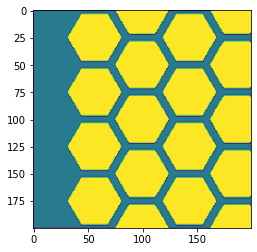

In [4]:
plt.imshow(img)

In [5]:
boundaryClass = np.array(img)

#boundaryClass = np.transpose(boundaryClass)
boundaryClass

#if a particle is at [y][x] then it will have the said boundary conditions
#eg [1][0] will have the boundary condition 8 (cannot move up)


array([[ 6,  8,  8, ..., 32, 32, 32],
       [14, 16, 16, ..., 32, 32, 32],
       [14, 16, 16, ..., 32, 32, 32],
       ...,
       [14, 16, 16, ..., 32, 32, 32],
       [14, 16, 16, ..., 32, 32, 32],
       [10, 12, 12, ..., 32, 32, 32]], dtype=uint8)

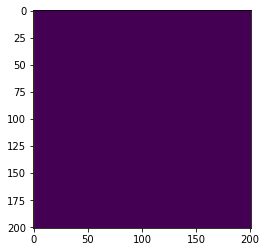

In [6]:
plt.imshow(image)

In [7]:
def pixelClass(ii):
    x, y = int(ii[0]), int(ii[1]) #don't transpose
    return boundaryClass[y][x]  #1 indexed

    #ok.


In [8]:
#x = []
#for i in sourceCoords:
 #   x.append(pixelClass(i))
#x

In [9]:
lookUpTable = pandas.read_csv('lookUpTable.csv')
lookUpTable = lookUpTable.values #removes the headers

#ok.


In [10]:
areaPerColumn = pandas.read_csv('VoidAreaPerColumn.csv')
areaPerColumn = areaPerColumn.values
areaPerColumn

array([['Hex_Porosity_0.13', 200, 200, ..., 16, 16, 16],
       ['Hex_Porosity_0.23', 200, 200, ..., 24, 24, 32],
       ['Hex_Porosity_0.34', 200, 200, ..., 40, 40, 56],
       ...,
       ['Hex_Porosity_0.87', 200, 200, ..., 200, 200, 200],
       ['Hex_Porosity_0.97', 200, 200, ..., 200, 200, 200],
       ['Hex_Porosity_1.00', 200, 200, ..., 200, 200, 200]], dtype=object)

In [11]:
sourceClass = np.array(image)
rows, cols = np.where(sourceClass == 255) #convert to 2d array
sourceCoords = np.empty((0,2))
i,j = 0,0
while i < len(rows) - 1:
    sourceCoords = np.append(sourceCoords, np.array([[cols[i], rows[j]]]), axis = 0)
    i += 1
    j += 1
numSource = len(sourceCoords)


In [12]:
dimImage = image.shape
Lx = dimImage[1] -1
Ly = dimImage[0] -1
Lx

200

In [13]:
#%% Define Parameters
    
## Simulation parameters
#Lx      = 500                   # length of system (500 um)
dx      = 1.00                  # camera pixel size (1 um)
nx      = round(Lx/dx)          # number of positions (pixels)
xx      = np.arange(nx+1)*dx    # x bin edges

#Ly      = 500                   # length of system (500 um)
dy      = 1.00                  # camera pixel size (1 um)
ny      = round(Ly/dy)          # number of positions (pixels)
yy      = np.arange(ny+1)*dy    # y bin edge

In [14]:
## Dynamic parameters
D               = 3          # diffusion constant
Decay_Time      = 30        # decay time in minutes
mu              = (Decay_Time*60) ** (-1)  # disassociation rate
J               = 0.0025            # Insertion rate (0.0015 tops at 660)

## Probabilities and derived parameters
dt      = dx**2/(D*2*2)         # assumes dy = dx
p_J     = J * dt  #number of source position
p_mu    = mu * dt
k_on = 0.6
k_off = 0.5
## Time Variables

Ttotal  = 2*60*60              # time in seconds
nt      = round(Ttotal/dt)+1
dtsave  = 60*12              # save every "10 mins"
dsave   = round(dtsave/dt)      
nsave   = round(Ttotal/dtsave)+1

In [15]:
start = time.time()
distribFree = np.empty((0,2))
distribBound = np.empty((0,2))
density = np.zeros((nx,nsave))
birthRate = J*numSource*dt
#p_bind = k_on*dt*(recepCoords.shape[0])
#p_unbind = k_off*dt*(recepCoords.shape[0])
moveDict = {'l':[-1,0],'r':[1,0], 'u':[0,-1],'d':[0,1]}
count = 0
c = 0
prev,current = 0,0
for count in range (1,nt):
    ##image source code##
    instBirth = np.random.poisson(birthRate) #random select number born at current time, replaces add
    for ii in range(1, instBirth +1):
        instSource = np.random.choice(numSource) #random select source position, replaces new
        new = [sourceCoords[instSource]]
        distribFree = np.append(distribFree, np.array(new), axis=0)#change shape of sourcePos[instSource]
    pixelClasses = np.empty(0, dtype=int)
    ##obstacle code##
    x = []
    for ii in distribFree: 
        x.append(pixelClass(ii)) #we have some 32's but will throw them away    
    for jj in range(1,17):
        x = np.array(x)
        indexPart = np.where(x == jj)[0] #returns the index in distrib where the particles have said class
        numInClass = len(indexPart)
        numFree = lookUpTable[jj-1][-1] #adjusts the index to the correct one
        randMove = np.random.uniform(low = 1, high = numFree+1, size = numInClass) # shape = len(idxP[0]),
        randMove = randMove.astype(int)
        blank = []
        if numFree> 0:
            moveDir = lookUpTable[jj-1][randMove] #returns a string (lrud), same shape as randMove
            for i in moveDir:
                blank.append(moveDict[i]) #shape = len(idxP[0]), 2
        blank = np.array(blank).reshape(-1,2).astype(int)
        distribFree[indexPart] = distribFree[indexPart] + blank
    numPartFree = len(distribFree) 
    ##binding/unbinding code##
    #partBound = np.empty((0,2), dtype= int)
    #numBind = np.random.poisson(p_bind)
    #numUnbind = np.random.poisson(p_unbind)
    #if numPartFree > 0:
     #   idxDict = {}
#        pbCount = 0
 #       for i in range(distribFree.shape[0]): 
  #          if (distribFree[i]== recepCoords).all(axis = 1).any(): #if the whole element matches
   #             partBound = np.append(partBound, np.array([distribFree[i]]), axis = 0)
    #            idxDict[pbCount] = i
     #           pbCount += 1
      #  if numBind < partBound.shape[0]:
       #     idxDel = []
        #    idxBind = np.random.choice(partBound.shape[0], numBind, replace = False)
         #   toBind = partBound[idxBind]
          #  for i in idxBind:
           #     k = idxDict[i]
  #              idxDel.append(k)
   #         distribFree = np.delete(distribFree, idxDel, axis = 0)
    #        distribBound = np.append(distribBound, toBind, axis = 0)
   # if numUnbind < distribBound.shape[0]:
    #    idxUnbind = np.random.choice(distribBound.shape[0], numUnbind, replace = False)
       # toUnbind = distribBound[idxUnbind]
      #  distribBound = np.delete(distribBound, idxUnbind, axis = 0)
     #   distribFree = np.append(distribFree, toUnbind, axis =0)
        #distribFree = np.array(distribFree).reshape(-1,2)
    ##kill code##
    numPartFree = len(distribFree)
    if numPartFree > 0:
        meanDecay = p_mu* numPartFree
        dead = np.random.poisson(meanDecay)
        kill = np.random.choice(numPartFree, dead, replace=False)
        distribFree = np.delete(distribFree,kill,0)
    if count%dsave == 0:
        ind = round(count/dsave) #change later
        print(f'At time step {count} out of {nt-1} with {len(distribFree) + len(distribBound)}  particles')
        #print(f'There are {len(distribBound)} bound and {len(distribFree)} free, with {len(partBound)} at receptors')
        #print(f'The {len(partBound)},{numBind} and {numUnbind} ')
        prev = current
        current = len(distribFree) + len(distribBound)
        #print(f'The previous is {prev} and current is {current}')
        #np.savetxt(str(ind)+'distribFree.csv', distribFree, fmt='%i', delimiter=",") #keep the data
        #np.savetxt(str(ind)+ 'distribBound.csv', distribBound, fmt ='%i', delimiter = ",") #keep the data
        img = np.zeros((Ly+1,Lx+1))
        for coord in distribFree:
            img[int(coord[1]) , int(coord[0])] +=1
        for coord in distribBound:
            img[int(coord[1]) , int(coord[0])] +=1
        im = Image.fromarray(img)
        #im.save(str(ind)+'.tif')
        ind = round(count/dsave) #change later
        distribX = np.array([])
        for i in distribFree:
            press = np.array([i[0]])
            distribX = np.concatenate ((distribX, press),)
        #for i in distribBound: 
         #   press = np.array([i[0]])
          #  distribX = np.concatenate ((distribX, press),)
        out, bins = np.histogram(distribX, xx)
        density[:,ind] = out / areaPerColumn[1][1:]
        if count >= 0.9*nt:
            if (count % 960) == 0:
                distribN = np.array([])
                for i in distribFree:
                    squeeze = np.array([i[0]])
                    distribN = np.concatenate ((distribN, squeeze),)
           #     for i in distribBound: 
            #        squeeze = np.array([i[0]])
             #       distribN = np.concatenate ((distribN, squeeze),)
                if c == 0:
                    
                    out, bins = np.histogram(distribN, xx)
                    out = out / areaPerColumn[1][1:]
                    denseNew = np.reshape(out, (200, 1))
                    denseOut = denseNew
                    c += 1
                else:
              #      for i in distribBound: 
               #         squeeze = np.array([i[0]])
                #    distribN = np.concatenate ((distribN, squeeze),)
                    
                    out, bins = np.histogram(distribN, xx)
                    out = out / areaPerColumn[1][1:]
                    denseNew = np.reshape(out, (200, 1))
                    denseOut = np.append(denseOut, denseNew, axis = 1)
        #if prev!= 0 and np.abs(current/prev-1) < 0.1:
         #   idx = []
          #  for i in range(distribFree.shape[0]): 
           #     if (distribFree[i]== killCoords).all(axis = 1).any(): #if the whole element matches
           #         idx.append(i)
            #distribFree = np.delete(distribFree, idx, axis = 0)
elapsed = time.time() - start

At time step 8640 out of 86400 with 299  particles
At time step 17280 out of 86400 with 493  particles
At time step 25920 out of 86400 with 632  particles
At time step 34560 out of 86400 with 721  particles
At time step 43200 out of 86400 with 762  particles
At time step 51840 out of 86400 with 784  particles
At time step 60480 out of 86400 with 816  particles
At time step 69120 out of 86400 with 843  particles
At time step 77760 out of 86400 with 923  particles
At time step 86400 out of 86400 with 883  particles


In [16]:
elapsed = time.time() - start
elapsed

605.6538391113281

In [17]:
#anly = sdd(xx, D, mu, J)
#color=iter(plt.cm.jet(np.linspace(0,1,nsave)))   
#for jj in range(nsave):
 #   c=next(color)
  #  plt.plot(np.arange(nx), density[:, jj], 
   #     'o', color=c, markersize=1, 
    #     label='t = ' + str(round(jj*1/2,1)) + 'h')   
#plt.plot(xx,anly, color=[0 ,0 ,0])
#plt.legend()
#plt.title('2D Stochastic Synthesis-Diffusion-Decay Simulation')
#plt.ylabel('X density/cell')
#plt.xlabel('X position ($\mu$m)')
#xi = np.arange(0,501,step = 100)
#plt.xticks(xi,xi);
#plt.savefig('2dsdd.png')

In [18]:
#File_data = np.loadtxt("test.txt", dtype=int)
#print(File_data) load in txt tile

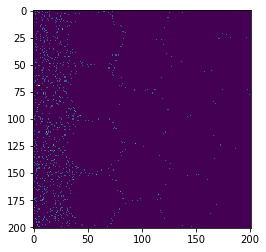

In [19]:
%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

#### Test Codes
-----------------------------

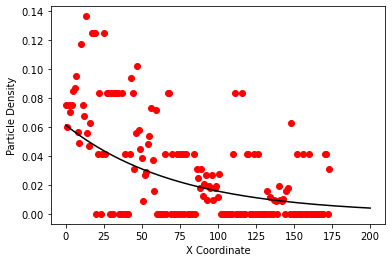

In [31]:
plt.plot(np.arange(nx-26), np.mean(denseOut[26:], axis=1), 'ro')
plt.plot(xx, sdd(xx, D, mu, J), 'k-', 0.1)
plt.xlabel('X Coordinate')
plt.ylabel('Particle Density')
plt.savefig('p0.23 trend.png')

In [21]:
out

array([0.1, 0.1, 0.115, 0.15, 0.12, 0.1, 0.09, 0.055, 0.15, 0.12, 0.12,
       0.075, 0.115, 0.125, 0.095, 0.085, 0.085, 0.055, 0.105, 0.07, 0.12,
       0.1, 0.11, 0.065, 0.09, 0.105, 0.075, 0.06, 0.075, 0.07, 0.075,
       0.085, 0.08695652173913043, 0.09523809523809523, 0.05625,
       0.04861111111111111, 0.1171875, 0.075, 0.0673076923076923,
       0.13636363636363635, 0.05555555555555555, 0.046875, 0.0625, 0.125,
       0.125, 0.125, 0.0, 0.041666666666666664, 0.08333333333333333, 0.0,
       0.041666666666666664, 0.125, 0.041666666666666664,
       0.08333333333333333, 0.08333333333333333, 0.0, 0.08333333333333333,
       0.0, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333,
       0.0, 0.0, 0.08333333333333333, 0.0, 0.041666666666666664, 0.0, 0.0,
       0.041666666666666664, 0.09375, 0.08333333333333333, 0.03125,
       0.05555555555555555, 0.10227272727272728, 0.057692307692307696,
       0.044642857142857144, 0.038461538461538464, 0.008928571428571428,
       0

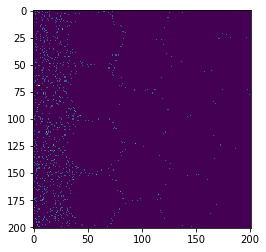

In [30]:
img = np.zeros((Ly+1,Lx+1))
for coord in distribFree:
    img[int(coord[1]) , int(coord[0])] +=1
for coord in distribBound:
    img[int(coord[1]) , int(coord[0])] +=1
im = Image.fromarray(img)

#colors = [(0, 0, 0), (0, 1, 0)] # first color is black, last is red
#cm = LinearSegmentedColormap.from_list(
    #    "Custom", colors, N=50)
#plt.imshow(img, cmap=cm)
plt.imshow(img, interpolation='nearest')
#plt.show()
plt.show()
im.save('0.23.tif')

In [23]:
np.amax(distribFree[1][:])

158.0

In [24]:
distribFree.shape

(883, 2)

In [25]:
a = []
for i in distribFree:
    a.append(pixelClass(i))
a


[16,
 14,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 14,
 16,
 16,
 11,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 8,
 16,
 16,
 16,
 16,
 8,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 7,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 12,
 16,
 16,
 16,
 16,
 16,
 16,
 12,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 8,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 14,
 16,
 16,
 16,
 16,
 16,
 16,
 12,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,

In [26]:
distribBound

array([], shape=(0, 2), dtype=float64)

In [27]:
np.amax(img)

3.0

In [28]:
from scipy.optimize import curve_fit
def expFn(x, a, b):
    return a * np.exp(b * -x)

# We see only the latter half of the data
ydata = np.mean(denseOut, axis=1)[26:]
xdata = np.arange(0,174)

popt, pcov = curve_fit(expFn, xdata, ydata)
D_pred = mu/popt[1]**2
D_pred

1.9852795799120078